### We saw that the toy example is not linearly separable. Let's try to classify it using random features. Namely, we will use unimodal features, white noise features, and bandpass features to classify the time series.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from estimator import RFClassifier, relu
from data_fns import noisy_sin_signal, data_matrix, butter_bandpass_filter
import dask

In [2]:
from dask.distributed import Client
client = Client(threads_per_worker=7, n_workers=10)
client

Client Scheduler: tcp://127.0.0.1:41187 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 10 Cores: 70 Memory: 135.06 GB


In [3]:
def bp_weights(M, N, lowcut, highcut, fs):
    J = np.random.randn(M, N)
    J = butter_bandpass_filter(J, lowcut, highcut, fs)
    return J.T

def l_clf(classifier, params, X_train, y_train, X_test, y_test):
    clf = classifier(**params)
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)

__First, we will generate data.__

In [56]:
# generate data
fs, dur, sig_dur, f_signal = 2000, 10, 0.05, 80
a = 0.01
signal, label = noisy_sin_signal(f_s=fs, dur=dur, sig_dur=sig_dur, f_signal=f_signal, a=a)

delta = 0.07
N = int(delta * 2000)
X, y = data_matrix(signal, label, N)

idx = int(len(X) * 2 / 3)
X_train, y_train = X[:idx], y[:idx]
X_test, y_test = X[idx:], y[idx:]

__Now, we will classify the example using random features.__

In [57]:
n_features = sorted(set(np.logspace(0, 3, 25).astype('int')))
print(n_features)

[1, 2, 3, 4, 5, 7, 10, 13, 17, 23, 31, 42, 56, 74, 100, 133, 177, 237, 316, 421, 562, 749, 1000]


In [58]:
%%time
# gaussian features
results_gaus= []
for n in n_features:
    params = {'width': n, 'weights': 'unimodal', 'nonlinearity': relu}
    lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, y_test) for _ in range(10)]
    results_gaus.append(dask.compute(*lazy_results))
    
mean_gaus = 1 - np.mean(results_gaus, axis=1)
std_gaus = np.std(results_gaus, axis=1)

CPU times: user 41.8 s, sys: 28.3 s, total: 1min 10s
Wall time: 4min


In [59]:
%%time 
# white noise features
results_whitenoise = []
for n in n_features:
    params = {'width': n, 'weights': 'white noise', 'nonlinearity': relu}
    lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, y_test) for _ in range(10)]
    results_whitenoise.append(dask.compute(*lazy_results))

mean_whitenoise = 1 - np.mean(results_whitenoise, axis=1)
std_whitenoise = np.std(results_whitenoise, axis=1)

CPU times: user 42.1 s, sys: 27.9 s, total: 1min 10s
Wall time: 4min 6s


In [60]:
%%time 
f = lambda M, N: bp_weights(M, N, lowcut=30, highcut=100, fs=2000)
# band pass features
results_bp = []
for n in n_features:
    params = {'width': n, 'weights': 'bandpass', 'weight_fun': f, 'nonlinearity': relu}
    lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, y_test) for _ in range(10)]
    results_bp.append(dask.compute(*lazy_results))

mean_bp = 1 - np.mean(results_bp, axis=1)
std_bp = np.std(results_bp, axis=1)

CPU times: user 37.7 s, sys: 26.4 s, total: 1min 4s
Wall time: 4min 1s


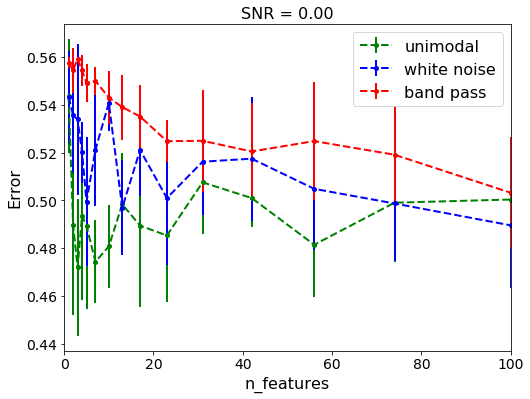

In [62]:
# plot
snr = a ** 2 / (1 - a ** 2)
fig = plt.figure(figsize=(8, 6))
plt.title('SNR = %0.2f' % snr, fontsize=16)
plt.errorbar(n_features, mean_gaus, yerr=std_gaus, fmt='--go', label='unimodal', markersize=4, lw=2)
plt.errorbar(n_features, mean_whitenoise, yerr=std_whitenoise, fmt='--bo', label='white noise', markersize=4, lw=2)
plt.errorbar(n_features, mean_bp, yerr=std_bp, fmt='--ro', label='band pass', markersize=4, lw=2)
plt.legend(fontsize=16)
plt.xlabel('n_features', fontsize=16)
plt.ylabel('Error', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/rand_classification/clf_a=%0.2f.png' % a)

plt.xlim(0, 100)
plt.savefig('figures/rand_classification/clf_a=%0.2f_zoomed.png' % a)

In [48]:
ls figures/rand_classification/

clf_a=0.80.png  clf_a=0.80_zoomed.png  clf_a=1.00.png  clf_a=1.00_zoomed.png
